In [1]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
input_file = 'HepG2_SDOC_active_result.tsv'
infos = pd.read_csv(input_file, sep="\t", header=None)
infos

,0,1,2,3,4,5
0,chr1,2190000,3430000,10,0.437330,0.614114
1,chr1,3430000,5990000,0,1.050111,-0.520215
2,chr1,5990000,6040000,0,0.003852,-0.520215
3,chr1,6040000,6700000,3,0.203751,0.525532
4,chr1,6700000,7660000,0,0.222518,-0.520215
...,...,...,...,...,...,...
2637,chr9,136730000,136790000,0,0.006576,-0.520215
2638,chr9,136790000,136940000,34,0.024912,2.321254
2639,chr9,136940000,137120000,0,0.046040,-0.520215
2640,chr9,137120000,137280000,0,0.032555,-0.520215


In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

figure_size = dict(
    ultra=45,
    large=35,
    middle=20,
    small=10,
    very_small=5
)

def set_plt(figsize=(10, 10)):
    params = {'axes.titlesize': figure_size['ultra'],
              'legend.fontsize': figure_size['middle'],
              'figure.figsize': figsize,
              'axes.labelsize': figure_size['ultra'],
              'xtick.labelsize': figure_size['ultra'],
              'ytick.labelsize': figure_size['ultra'],
              'figure.titlesize': figure_size['ultra'],
              'lines.linewidth': figure_size['very_small']}
    plt.rcParams.update(params)

    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)

def set_Border(axes):
    axes.spines['top'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.spines['bottom'].set_color('black')
    axes.spines['left'].set_color('black')
    axes.spines['bottom'].set_linewidth(figure_size['very_small'])
    axes.spines['left'].set_linewidth(figure_size['very_small'])
    axes.tick_params(axis='both', width=figure_size['very_small'], length=figure_size['small'])

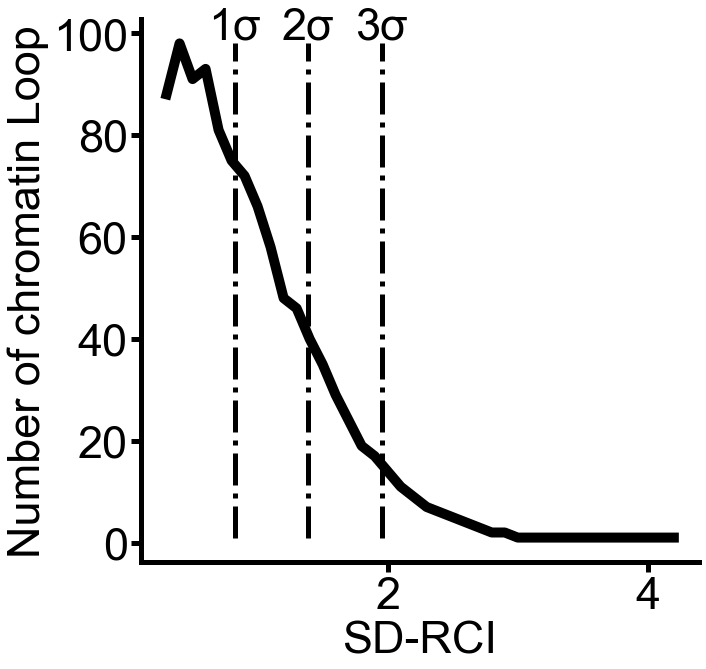

In [4]:
result = infos.loc[infos[3]>0].loc[:,5].round(1).value_counts().sort_index()
x = result.index.tolist()
y = result.values.tolist()

_sigma = infos.loc[infos[3]>0].loc[:,5].std()
_min = infos.loc[infos[3]>0].loc[:,5].min()
_thresholds = [_min+i*_sigma for i in range(1, 4)]

set_plt()
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.plot(x, y, color='black', linewidth=figure_size['small'])
for i in range(3):
    axes.vlines(
        _thresholds[i], result.values.min(), result.values.max(),
        colors='black', linestyles='dashdot'
    )
    axes.text(
        _thresholds[i], result.values.max()+1, '{}σ'.format(i+1),
        fontsize=figure_size['ultra'], horizontalalignment='center'
    )

set_Border(axes)
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])

plt.xlabel('SD-RCI')
plt.ylabel('Number of chromatin Loop')
plt.show()

In [5]:
low = infos.loc[infos[3]>0].loc[infos[5]<_thresholds[0]].copy()
middle = infos.loc[infos[3]>0].loc[infos[5]>=_thresholds[0]].loc[infos[5]<_thresholds[1]].copy()
high = infos.loc[infos[3]>0].loc[infos[5]>=_thresholds[1]].loc[infos[5]<_thresholds[2]].copy()
ultra_high = infos.loc[infos[3]>0].loc[infos[5]>=_thresholds[2]].copy()

In [6]:
SE = pd.read_table(
    "/data1/lmh_data/MINE/source/HepG2/SE_01_0038_SE.bed",
    header=None, names=[
        'cell_id', 'se_id', 'se_chr', 'se_start', 'se_end',
        'se_rank', 'se_ele_num', 'se_snp_num', 'se_eqtl_num',
        'se_gwas_num', 'se_tfbs_num', 'se_crisps_num', 'se_conser_score',
        'se_cas_value', 'se_con_value', 'se_gene_overlap', 'se_gene_proximal',
        'se_gene_closest', 'se_gene_lasso', 'se_gene_prestige', 'se_gene_closest_active'
    ]
)
TE = pd.read_table(
    "/data1/lmh_data/MINE/source/HepG2/SE_01_0038_TE.bed",
    header=None, names=[
        'te_chr', 'te_start', 'te_end', 'cell_id', 'te_id',
        'te_rank', 'te_ele_num', 'te_CONSTITUENT_SIZE',
        'te_cas_value', 'te_con_value', 'te_gene_overlap',
        'te_gene_proximal', 'te_gene_closest', 'isSUPER'
    ]
)

def get_super_enhancer_ele_num(df):
    _total = 0
    for i, r in df.iterrows():
        chrom, start, end = r[0:3]
        _total += SE[(SE['se_chr']==chrom)&(SE['se_start'] >= start)&(SE['se_end'] <= end)]['se_ele_num'].sum()
    return _total

def get_super_enhancer_ele_density(df):
    _total = 0
    for i, r in df.iterrows():
        chrom, start, end = r[0:3]
        _total += SE[(SE['se_chr']==chrom)&(SE['se_start'] >= start)&(SE['se_end'] <= end)
                    ]['se_ele_num'].sum() / (end - start) * 1000
    return _total

def get_typical_enhancer_ele_num(df):
    _total = 0
    for i, r in df.iterrows():
        chrom, start, end = r[0:3]
        _total += TE[(TE['te_chr']==chrom)&(TE['te_start'] >= start)&(TE['te_end'] <= end)]['te_ele_num'].sum()
    return _total

def get_typical_enhancer_ele_density(df):
    _total = 0
    for i, r in df.iterrows():
        chrom, start, end = r[0:3]
        _total += TE[(TE['te_chr']==chrom)&(TE['te_start'] >= start)&(TE['te_end'] <= end)
                    ]['te_ele_num'].sum() / (end - start) * 1000
    return _total

def find_gene(df, use_SE=True, use_TE=True):
    _total = []
    for i, r in df.iterrows():
        chrom, start, end = r[0:3]

        if use_SE:
            tmp = SE[(SE['se_chr']==chrom)&(SE['se_start'] >= start)&(SE['se_end'] <= end)].loc[:, [
                'se_gene_overlap', 'se_gene_proximal', 'se_gene_closest', 'se_gene_lasso',
                'se_gene_prestige', 'se_gene_closest_active']].values.flatten().astype(str)
            _tmp = []
            [_tmp.extend(i.split(',')) for i in tmp]
            tmp = np.array(_tmp).astype(str)
            _total.extend(tmp[tmp != 'nan'].tolist())

        if use_TE:
            tmp = TE[(TE['te_chr']==chrom)&(TE['te_start'] >= start)&(TE['te_end'] <= end)].loc[:, [
                'te_gene_overlap', 'te_gene_proximal', 'te_gene_closest']].values.flatten().astype(str)
            _tmp = []
            [_tmp.extend(i.split(',')) for i in tmp]
            tmp = np.array(_tmp).astype(str)
            _total.extend(tmp[(tmp != 'nan')&(tmp != '.')].tolist())
    return list(set(_total))

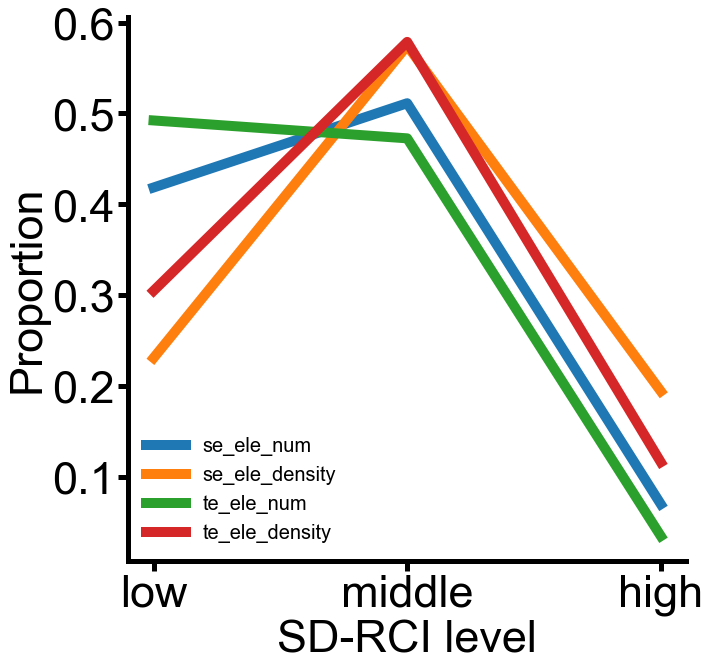

In [7]:
result = dict()
result['se_ele_num'] = [
    get_super_enhancer_ele_num(low),
    get_super_enhancer_ele_num(middle) + get_super_enhancer_ele_num(high),
    get_super_enhancer_ele_num(ultra_high)
]
result['se_ele_num'] /= sum(result['se_ele_num'])
result['se_ele_density'] = [
    get_super_enhancer_ele_density(low),
    get_super_enhancer_ele_density(middle) + get_super_enhancer_ele_density(high),
    get_super_enhancer_ele_density(ultra_high)
]
result['se_ele_density'] /= sum(result['se_ele_density'])

result['te_ele_num'] = [
    get_typical_enhancer_ele_num(low),
    get_typical_enhancer_ele_num(middle) + get_typical_enhancer_ele_num(high),
    get_typical_enhancer_ele_num(ultra_high)
]
result['te_ele_num'] /= sum(result['te_ele_num'])
result['te_ele_density'] = [
    get_typical_enhancer_ele_density(low),
    get_typical_enhancer_ele_density(middle) + get_typical_enhancer_ele_density(high),
    get_typical_enhancer_ele_density(ultra_high)
]
result['te_ele_density'] /= sum(result['te_ele_density'])

x = ['low', 'middle', 'high']
set_plt()
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.plot(x, result['se_ele_num'], linewidth=figure_size['small'], label='se_ele_num')
axes.plot(x, result['se_ele_density'], linewidth=figure_size['small'], label='se_ele_density')
axes.plot(x, result['te_ele_num'], linewidth=figure_size['small'], label='te_ele_num')
axes.plot(x, result['te_ele_density'], linewidth=figure_size['small'], label='te_ele_density')

set_Border(axes)
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])

plt.legend(frameon=False)
plt.xlabel('SD-RCI level')
plt.ylabel('Proportion')
plt.savefig('figure_file/The relationship between SD-RCI and enhancer-element.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [8]:
rna = pd.read_table('/data1/lmh_data/MINE/source/HepaRG_Batch1_191226.csv', sep=',')
# rna = rna.set_index('symbol')
rna

,symbol,Day0,SP_Day1,SP_Day3,SP_Day5,ST_Day1,ST_Day3,ST_Day5,2D_Day1,2D_Day3,2D_Day5
0,A1BG,0.062501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,A1BG-AS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,A1CF,1.924820,1.275020,4.507150,6.017080,2.791030,2.138870,3.323470,1.304830,1.139200,2.315930
3,A2M,1.327300,0.586043,3.314240,8.370110,0.783798,0.112507,0.882933,0.827809,0.104642,0.083684
4,A2M-AS1,0.148086,0.093438,0.098504,0.041710,0.080133,0.100063,0.000000,0.038554,0.078098,0.187368
...,...,...,...,...,...,...,...,...,...,...,...
26250,ZYG11A,0.919537,2.197190,1.211960,0.947031,1.448450,1.352900,1.247680,2.961140,2.918550,2.829640
26251,ZYG11B,3.267120,1.950820,2.618920,3.169710,2.314230,2.909900,3.160620,4.693910,4.871310,5.463380
26252,ZYX,97.060500,234.170000,108.590000,104.363000,165.769000,150.548000,150.158000,123.678000,95.676100,73.236900
26253,ZZEF1,1.992840,3.294880,4.996150,5.488070,4.434920,3.081780,3.663680,4.299470,4.740180,5.181750


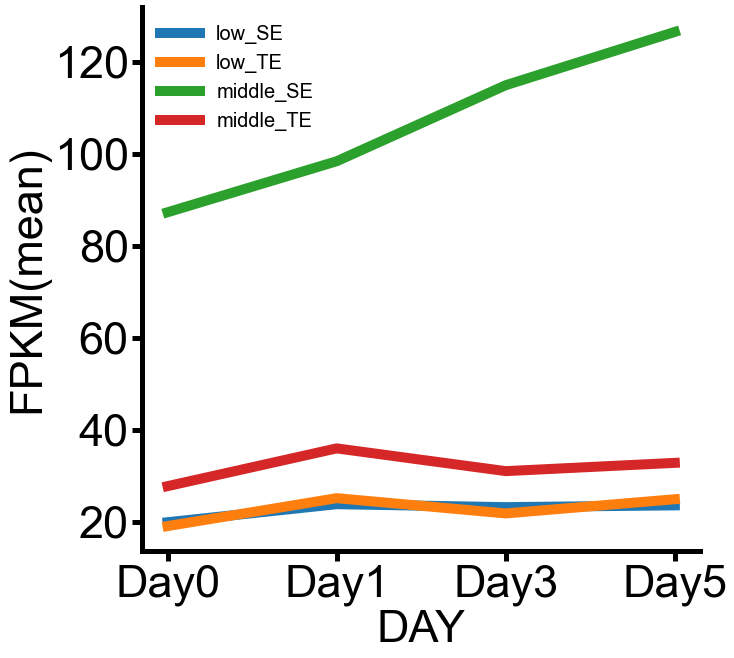

In [9]:
def get_rna(df):
    _rna = rna[rna.symbol.isin(df)].loc[:, ['Day0', 'SP_Day1', 'SP_Day3', 'SP_Day5']]
    _rna.rename(columns={'SP_Day1':'Day1','SP_Day3':'Day3','SP_Day5':'Day5'}, inplace=True)
    return _rna

_low_SE = get_rna(find_gene(low, True, False)).mean()
_low_TE = get_rna(find_gene(low, False, True)).mean()

tt = find_gene(middle, True, False).copy()
tt.extend(find_gene(high, True, False))
_middle_SE = get_rna(tt).mean()
tt = find_gene(middle, False, True).copy()
tt.extend(find_gene(high, False, True))
_middle_TE = get_rna(tt).mean()

x = ['Day0', 'Day1', 'Day3', 'Day5']
set_plt()
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
axes.grid(False)
axes.plot(x, _low_SE.values, linewidth=figure_size['small'], label='low_SE')
axes.plot(x, _low_TE.values, linewidth=figure_size['small'], label='low_TE')
axes.plot(x, _middle_SE.values, linewidth=figure_size['small'], label='middle_SE')
axes.plot(x, _middle_TE.values, linewidth=figure_size['small'], label='middle_TE')

set_Border(axes)
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])

plt.legend(frameon=False)
plt.xlabel('DAY')
plt.ylabel('FPKM(mean)')
plt.savefig('figure_file/The relationship between Day and fpkm.pdf', format='pdf', bbox_inches='tight')
plt.show()